### Import packages

In [1]:
import sys
sys.path.append('../')
import numpy as np
from gmm_mi import GMM, GMM_MI
from utils.synthetic_data import D1 as dataset
from utils.plotting import plot_gmm_contours, histogram_estimates, plot_loss_curves

### Calculate the true MI of the synthetic model, and plot contours

0.08719243298747173


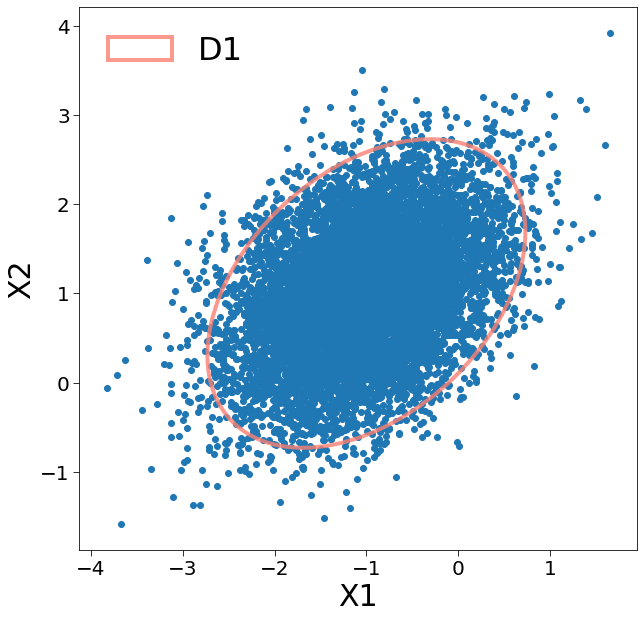

In [2]:
label = 'D1'
analytic = dataset.estimate_MI_MC(MC_samples=1e8)
print(analytic)
plot_gmm_contours(dataset, ls='-', label=label)

### Test on 500 trials

In [ ]:
N = 10000
random_states = 500

# parameters to play with
n_inits = 10
n_folds = 5
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-15
max_iter = 10000
MC_samples = 1e5
bootstrap = False
fixed_components = True
n_bootstrap = 100
all_MI_estimates = np.zeros((random_states))

for r in range(random_states):
    
    n_components = dataset.n_components 
    true_weights = dataset.weights_
    true_means = dataset.means_
    true_covariances = dataset.covariances_

    X = GMM(n_components=n_components, weights_init=true_weights, 
                      means_init=true_means, covariances_init=true_covariances, 
                      random_state=r+5000).sample(N)[0]

    MI_mean, _, lc = GMM_MI(X, n_folds=n_folds, n_inits=n_inits, 
                         init_type=init_type, reg_covar=reg_covar, tol=tol, max_iter=max_iter,
                         bootstrap=bootstrap, n_bootstrap=n_bootstrap, MC_samples=MC_samples, 
                         fixed_components=fixed_components, fixed_components_number=n_components)
    


    # print for debugging purposes
    print(r, MI_mean) 

    all_MI_estimates[r] = MI_mean

    # save, if needed
    #np.save('./D3p_bias_MI_test.npy', all_MI_estimates)

Convergence reached at 1 components
0 0.09065261211483794
Convergence reached at 1 components
1 0.08262272522780417
Convergence reached at 1 components
2 0.08256639346019008
Convergence reached at 1 components
3 0.08307196577460017
Convergence reached at 1 components
4 0.09235088802194792
Convergence reached at 1 components
5 0.08560623729942692
Convergence reached at 1 components
6 0.08844737999349991
Convergence reached at 1 components
7 0.0791892839351184
Convergence reached at 1 components
8 0.08505511247316308
Convergence reached at 1 components
9 0.08838157425136671
Convergence reached at 1 components
10 0.08581552771834879
Convergence reached at 1 components
11 0.08969233432833475
Convergence reached at 1 components
12 0.09354008952896098
Convergence reached at 1 components
13 0.08617139387976824
Convergence reached at 1 components
14 0.0837068781314587
Convergence reached at 1 components
15 0.09151266067094019
Convergence reached at 1 components
16 0.09011164156954504
Convergen

Convergence reached at 1 components
139 0.09002104641616819
Convergence reached at 1 components
140 0.08465158215616506
Convergence reached at 1 components
141 0.08568431370141287
Convergence reached at 1 components
142 0.08423084299672426
Convergence reached at 1 components
143 0.07620848670273965
Convergence reached at 1 components
144 0.09166125773707001
Convergence reached at 1 components
145 0.08530913202670426
Convergence reached at 1 components
146 0.08223044468938041
Convergence reached at 1 components
147 0.08788890749417866
Convergence reached at 1 components
148 0.08889976860381779
Convergence reached at 1 components
149 0.08617166064277047
Convergence reached at 1 components
150 0.08634820888741043
Convergence reached at 1 components
151 0.08536161768249877
Convergence reached at 1 components
152 0.08760815834537834
Convergence reached at 1 components
153 0.08332095056761891
Convergence reached at 1 components
154 0.08271996781179622
Convergence reached at 1 components
155 

Convergence reached at 1 components
276 0.08460065864642978
Convergence reached at 1 components
277 0.08938699151157384
Convergence reached at 1 components
278 0.08706773041116579
Convergence reached at 1 components
279 0.08983245435348977


### Evaluate MI bias

In [ ]:
# load in case you saved it
#all_MI_estimates = np.load('./D3p_bias_MI_test.npy')

In [ ]:
### then also try this one, but without the +50000 in the seed (5.7); also try aic, bic, and longer patience

In [ ]:
histogram_estimates(all_MI_estimates - analytic, title=f'{label}, {random_states} trials, without bootstrap, correct number of components.')

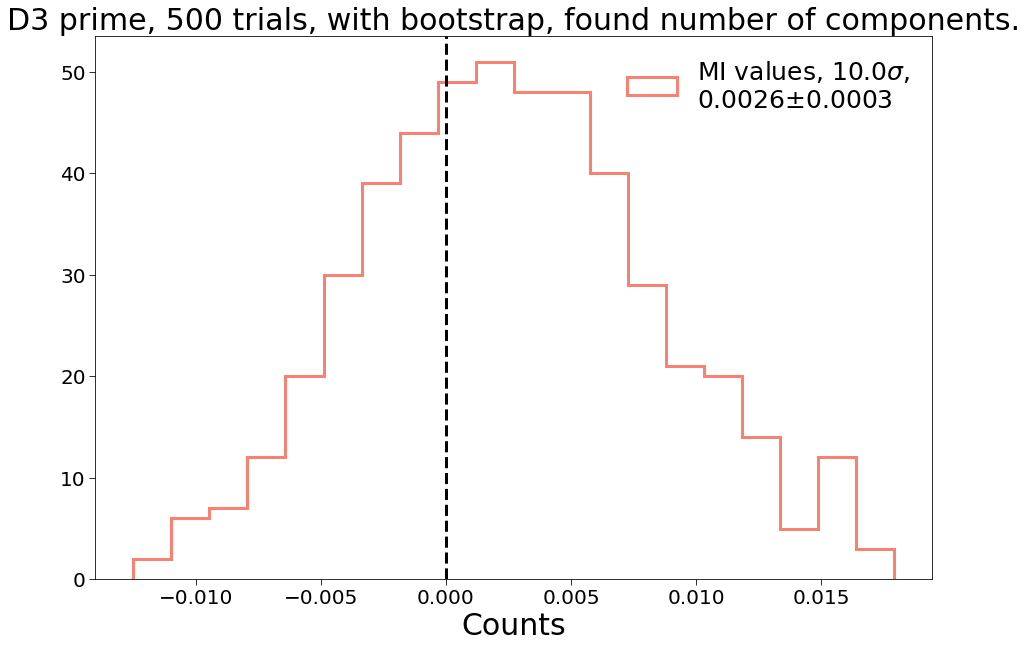

In [5]:
plot_MI_values(all_MI_estimates - analytic, title=f'D3 prime, {random_states} trials, with bootstrap, found number of components.')